# Flux with MNIST


## Libraries

In [1]:
#using CUDA

using Flux              # the julia ml library
using Images            # image processing and machine vision for julia

using MLJ               # make_blobs, rmse, confmat, f1score, coerce
#using MLJFlux           # NeuralNetworkClassifier, CUDALibs
using MLDataUtils       # label, nlabel, labelfreq, stratifiedobs
using MLDatasets        # mnist

using LinearAlgebra     # pinv pseudo-inverse matrix
#using Metrics           # r2-score
using Random
using StatsBase         # standardize (normalization)
using Distributions

using Plots; gr()
using StatsPlots
using Printf

#using CSV
using DataFrames


## Functions

In [2]:
# metrics
function printMetrics(ŷ, y)
    display(confmat(ŷ, y))
    println("accuracy: ", round(accuracy(ŷ, y); digits=3))
    println("f1-score: ", round(multiclass_f1score(ŷ, y); digits=3))
end


printMetrics (generic function with 1 method)

## Dataset

,,,,

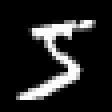
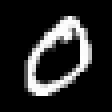
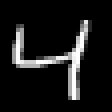
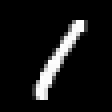
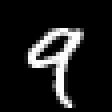

1×5 adjoint(::Vector{Int64}) with eltype Int64:
 5  0  4  1  9

In [3]:
# load mnist from MLDatasets
trainX_original,      trainY_original      = MNIST.traindata()
validationX_original, validationY_original = MNIST.testdata();

display([MNIST.convert2image(MNIST.traintensor(i)) for i in 1:5])
trainY_original[1:5]'

In [4]:
# split trainset, testset, validation set
Random.seed!(1)
(trainX, trainY), (testX, testY) = stratifiedobs((trainX_original, trainY_original), p = 0.7)
validationX = copy(validationX_original); validationY = copy(validationY_original)

size(trainX), size(testX), size(validationX)

((28, 28, 42001), (28, 28, 17999), (28, 28, 10000))

## Preprocessing

Flux primarily works with matrices and vectors

In [5]:
function preprocess(X, y)
    Xs = Float32.(X) |> Flux.flatten
    ys = Flux.onehotbatch( Float32.(y), 0:9 )
    
    return (Xs, ys)
end

h, v, N = size(trainX); d = h * v
X, y = preprocess(trainX, trainY);

In [6]:
d, N, size(X), size(y)

(784, 42001, (784, 42001), (10, 42001))

### tanh

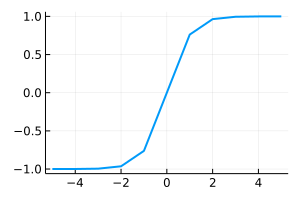

In [8]:
plot(-5:5, tanh.(-5:5), size=(300,200), linewidth=2, legend=false)


### Model

Stochastic Gradient Descent(SGD) means batchsize=1

The error on every and each data line is computed and weights are recalculated towards the negative of the gradient.

For this reason, calculation remains on CPU.

In [21]:
# model configuration
nInputs  = d
nOutputs = 10
model = Chain( Flux.Dense(nInputs, nOutputs, tanh), softmax )

losses(X, y)    = Flux.crossentropy( model(X), y )
modelParameters = Flux.params(model)
dataLoader      = Flux.DataLoader((X, y), batchsize=1)             # default batchsize=1
callBack        = Flux.throttle(() -> println("training"), 10);    # print every 10s


### Train

In [22]:
# Flux.train!(loss, params, data, opt; cb)
@time Flux.train!(losses, modelParameters, dataLoader, Flux.Descent())   # single epoch

# cpu time (batchsize=1): 3-4s

  3.365817 seconds (8.72 M allocations: 2.073 GiB, 4.31% gc time, 2.33% compilation time)


In [23]:
# preferred for multiple epochs
epochs = 10
@time for i in 1:epochs Flux.train!(losses, modelParameters, dataLoader, Flux.Descent(); cb=callBack) end

training
training
training
training
 34.135957 seconds (85.54 M allocations: 20.656 GiB, 3.75% gc time, 0.59% compilation time)


### Predict

In [24]:
function predictOutcome(X)
    ŷ = Flux.onecold( model(X), [0:9;] )
end


predictOutcome (generic function with 1 method)

,,,,,,,

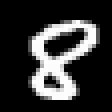
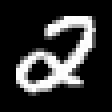
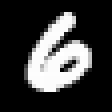
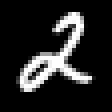
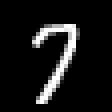
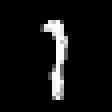
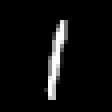
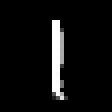

1×8 adjoint(::Vector{Int64}) with eltype Int64:
 8  2  6  2  7  1  1  1

In [25]:
ŷ = predictOutcome(X)

display([MNIST.convert2image(trainX[:,:,i]) for i in 1:8])
ŷ[1:8]'

In [26]:
printMetrics( coerce(ŷ, OrderedFactor), coerce(trainY, OrderedFactor) )

10×10 Matrix{Int64}:
 4069     3    53    41    24    70    39    29    59    44
    0  4389     8     9     7     7     9     6    27     6
    7    33  3707    85    15    20    10    42    36    13
    4    10    52  3822     2   148     0     4    72    62
    6     4    66     7  3637    50    46    44    23    68
    9    37    15   101     5  3181    50     6    77    23
   18     9    41    30    25    75  3933     2    30     2
    4    12    56    41    12    16     2  4113    11   121
   25   207   152   106    54   164    50    24  3721    52
    4    15    21    50   308    64     4   116    40  3773

accuracy: 0.913
f1-score: 0.912
